<a href="https://colab.research.google.com/github/GrueneKatze/GANs_Coursera/blob/main/C1W4B_Controllable_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Controllable Generation

##Goals
In this notebook, you're going to implement a GAN controllability method using gradients from a classifier. By training a classifier to recognize a relevant feature, you can use it to change the generator's inputs (z-vectors) to make it generate images with more or less of that feature.

You will be started you off with a pre-trained generator and classifier, so that you can focus on the controllability aspects. However, in case you would like to train your own classifier, the code for that has been provided as well.

##Learning Objectives
* Observe how controllability can change a generator's output.
* Resolve some of the challenges that entangled features pose to controllability.

##Getting started!
You will start off by importing useful libraries and packages and defining a visualization function. You have also been provided with the generator, noise, and classifier code from earlier assignments. The classifier has the same archicture as the earlier critic (remember that the discriminator/critic is simply a classifier used to classify real and fake).

**CelebA**

For this notebook, instead of the MNIST dataset, you will be using CelebA. CelebA is a dataset of annotated celebrity images. Since they are colored (not black-and-white), the images have three channels for red, green, and blue (RGB).

**Packages and Visualization**

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

**Generator and Noise**

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

**Classifier**

In [ ]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

**Specifying Parameters**

Before you begin training, you need to specify a few parameters:

* z_dim: the dimension of the noise vector
* batch_size: the number of images per forward/backward pass
* device: the device type

In [ ]:
z_dim = 64
batch_size = 128
device = 'cuda'

##Train a Classifier (Optional)
You're welcome to train your own classifier with this code, but you are provided with a pretrained one later in the code. Feel free to skip this code block, and if you do want to train your own classifier, it is recommended that you initially go through the assignment with the provided classifier!

In [ ]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
# train_classifier("filename")

## Training the Generator

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

In [ ]:
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
#dataset = DataLoader(
#   CelebA('.', download=True, transform=transform),
#   batch_size=batch_size,
#    shuffle=True)
dataset = CelebA(".", download=True, transform=transform)

In [ ]:
image_size = 64
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = classifier(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        outputs = mixed_scores, inputs = mixed_images,grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True, retain_graph=True,)[0]
    return gradient#,

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean(torch.square(gradient_norm - torch.ones_like(gradient_norm)))
    #### END CODE HERE ####
    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = - torch.mean(crit_fake_pred)
    return gen_loss

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


##Loading the Pretrained Models
You will then load the pretrained generator and classifier using the following code. (If you trained your own classifier, you can load that one here instead.)

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
#base_dir = root_dir + 'Basic_GANs/'
path_cr = Path(root_dir + 'Basic_GANs')

Mounted at /content/gdrive


In [ ]:
image_size = 299
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
#dataset = CelebA(".", download=True, transform=transform)

In [ ]:
#!echo "----------------------- downloading pretrained model on celeba face dataset -----------------------"
#!curl -o pretrained_celeba.zip "https://www.robots.ox.ac.uk/~vgg/research/unsup3d/data/pretrained_celeba.zip" && unzip pretrained_celeba.zip
#/content/gdrive/MyDrive/Basic_GANs

In [ ]:
#!wget -q -O pretrained_celeba.pth "https://drive.google.com/uc?id=1Hp3A7cAmCPWwPtKzp9sj91jF1szwioJS"

In [ ]:
#import torch
#gen = Generator(z_dim).to(device)
#gen_dict = torch.load('/content/gdrive/MyDrive/Basic_GANs/pretrained_celeba.pth', map_location=torch.device(device))["gen"]
#gen_dict = torch.load('/content/pretrained_celeba/checkpoint030.pth', map_location=torch.device(device))["gen"]

#gen.load_state_dict(gen_dict)
#gen.eval()

In [ ]:
import torch
#gen = Generator(z_dim).to(device)
#gen_dict = torch.load('/content/gdrive/MyDrive/Basic_GANs/W4_pretrained_celeba.pth', map_location=torch.device(device))["gen"]
#gen.load_state_dict(gen_dict)
#gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load('/content/gdrive/MyDrive/Basic_GANs/W4_pretrained_classifier.pth', map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


##Training
Now you can start implementing a method for controlling your GAN!

####Update Noise
For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by new = old + (∇ old * weight), where ∇ is the gradient of old. You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

Given the noise with its gradient already calculated through the classifier, you want to return the new noise vector.

In [ ]:
# GRADED FUNCTION: calculate_updated_noise
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    #### START CODE HERE ####
    new_noise = noise + (noise.grad*weight)
    return new_noise

In [ ]:
# UNIT TEST
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [ ]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

####Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.



In [ ]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Attractive") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

####Entanglement and Regularization
You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_score
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight. 
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    #### START CODE HERE ####
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    #change_or_cur_norm = torch.norm(current_classifications[:, other_indices] - original_classifications[:, other_indices], dim=1)
    other_class_penalty = -torch.mean(torch.norm(current_classifications[:, other_indices] - original_classifications[:, other_indices], dim=1))*penalty_weight
    #other_class_penalty = -torch.mean(change_or_cur_norm)*penalty_weight
    target_score = torch.mean(current_classifications[:, target_indices])
    return target_score + other_class_penalty



In [ ]:
# UNIT TEST
assert torch.isclose(
    get_score(torch.ones(4, 3), torch.zeros(4, 3), [0], [1, 2], 0.2), 
    1 - torch.sqrt(torch.tensor(2.)) * 0.2
)
rows = 10
current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()

# Must be 3
assert get_score(current_class, original_class, [1, 3] , [0, 2], 0.2).item() == 3

current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[4] * rows, [4] * rows, [2] * rows, [1] * rows]).T.float()

# Must be 3 - 0.2 * sqrt(10)
assert torch.isclose(get_score(current_class, original_class, [1, 3] , [0, 2], 0.2), 
                     -torch.sqrt(torch.tensor(10.0)) * 0.2 + 3)

print("Success!")

Success!


Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats.

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: combine_vectors
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    return torch.cat((x.float(),y.float()),1) #FloatTensor

In [ ]:
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]));
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
print("Success!")

Success!


##Training
Now you can start to put it all together! First, you will define some new parameters:

* mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
* n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [ ]:
mnist_shape = (1, 28, 28)
n_classes = 10

And you also include the same parameters from previous assignments:

* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* device: the device type

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_input_dimensions
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0]+n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()
print("Success!")

Success!


In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:

* Tell that to the generator, so that it knows it should be generating a "1"
* Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake

There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!



Step 500: Generator loss: 4.63115158367157, discriminator loss: 0.06189167881011963


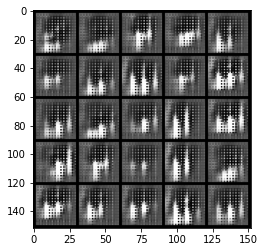

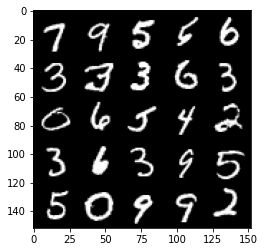

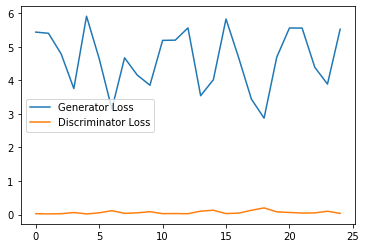

Step 1000: Generator loss: 4.091594284534454, discriminator loss: 0.06182898958213627


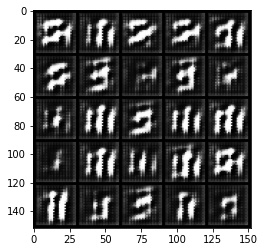

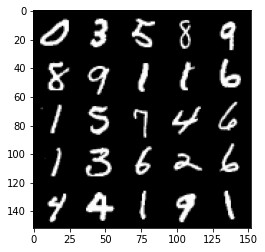

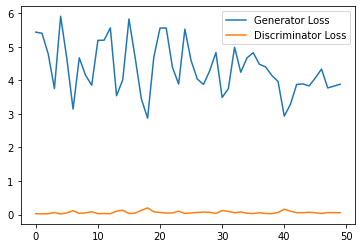

Step 1500: Generator loss: 3.4726708149909973, discriminator loss: 0.11906758311390876


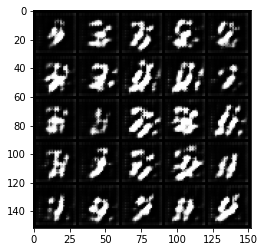

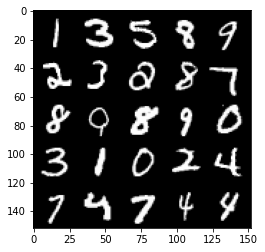

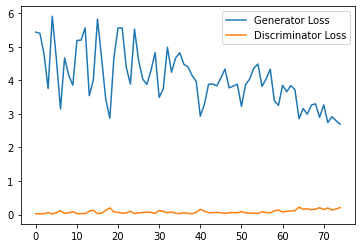

Step 2000: Generator loss: 2.675552643537521, discriminator loss: 0.2016039021015167


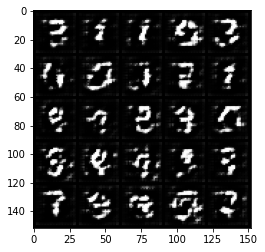

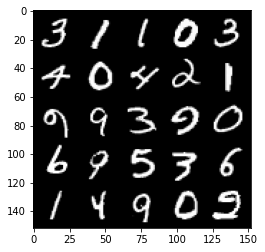

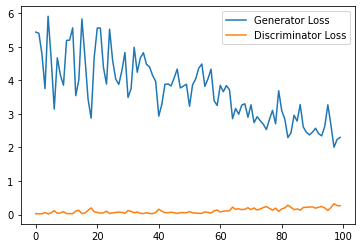

Step 2500: Generator loss: 2.3560661180019378, discriminator loss: 0.2698821043968201


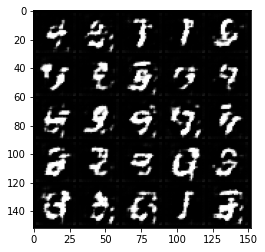

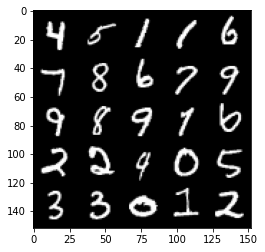

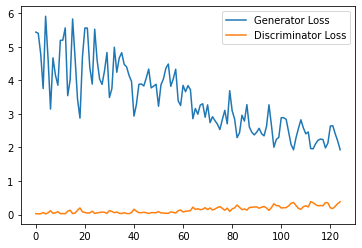

Step 3000: Generator loss: 2.148840746641159, discriminator loss: 0.30606387615203856


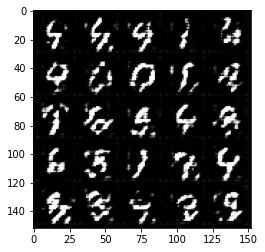

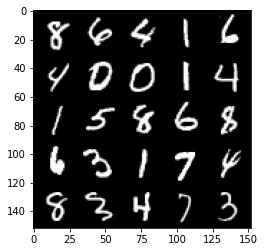

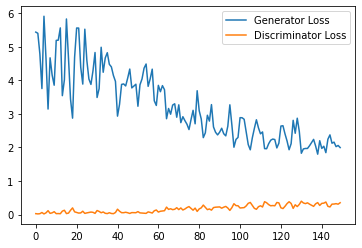

Step 3500: Generator loss: 2.1866294882297517, discriminator loss: 0.30620453172922135


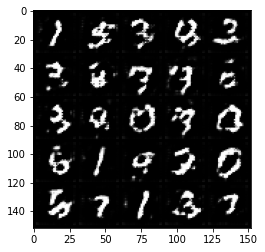

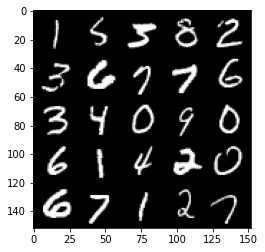

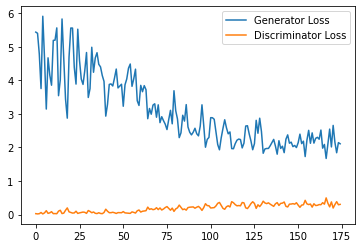

Step 4000: Generator loss: 2.217113299846649, discriminator loss: 0.30243930432200433


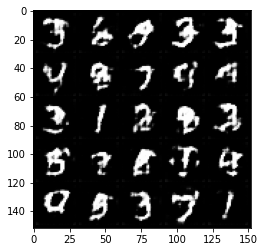

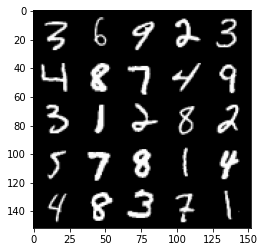

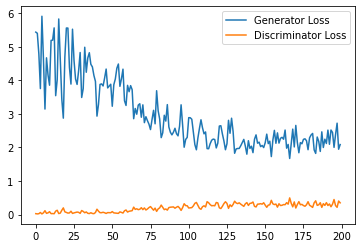

Step 4500: Generator loss: 2.00799409198761, discriminator loss: 0.3520853233337402


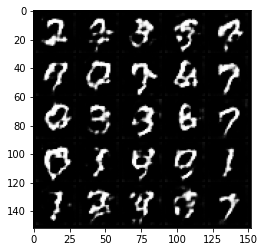

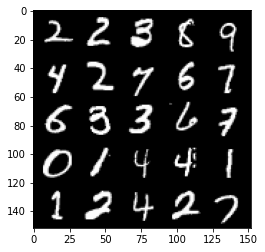

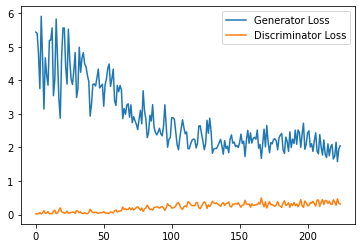

Step 5000: Generator loss: 1.9036309707164765, discriminator loss: 0.3705187681615353


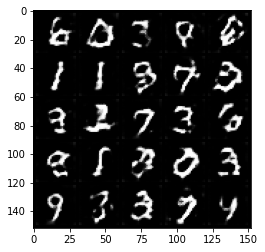

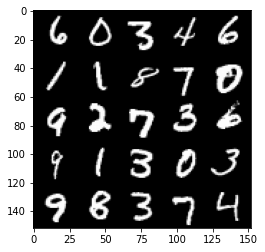

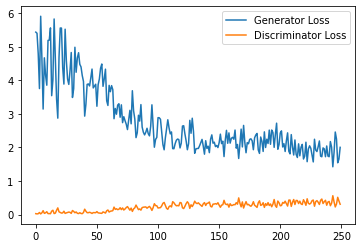

Step 5500: Generator loss: 1.8029214086532592, discriminator loss: 0.39634247550368307


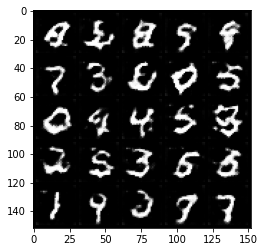

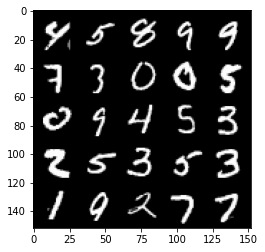

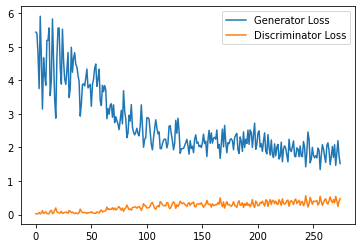

Step 6000: Generator loss: 1.6114646328687667, discriminator loss: 0.41036879006028176


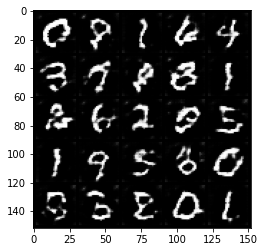

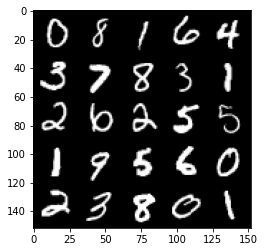

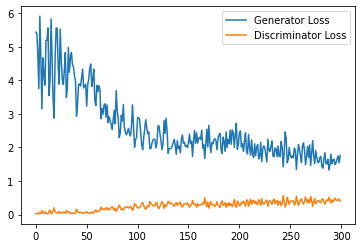

Step 6500: Generator loss: 1.651695384502411, discriminator loss: 0.44127364313602446


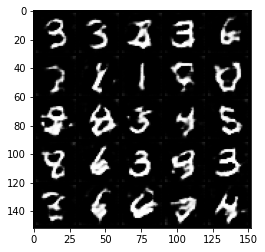

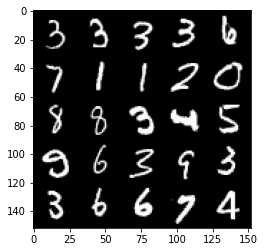

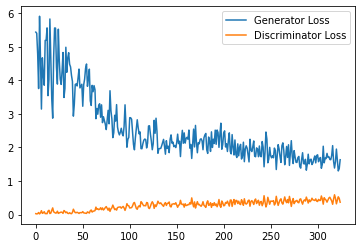

Step 7000: Generator loss: 1.44207273375988, discriminator loss: 0.4595170837044716


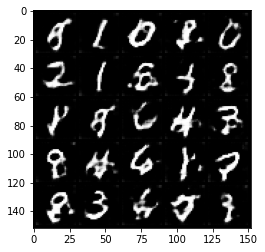

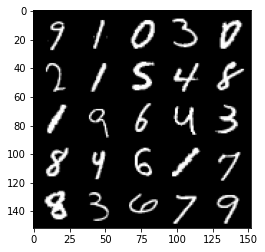

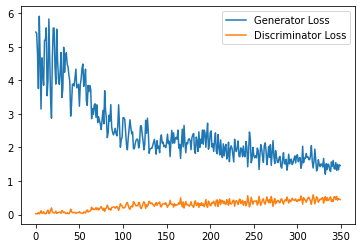

Step 7500: Generator loss: 1.3968450305461884, discriminator loss: 0.4908059325814247


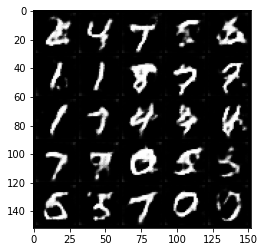

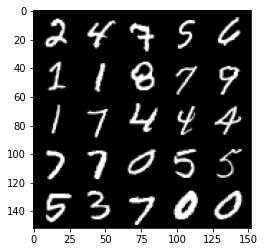

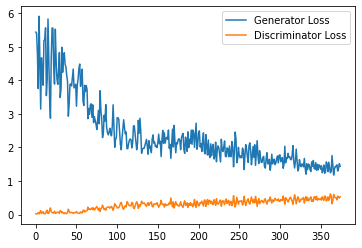

Step 8000: Generator loss: 1.4321557284593582, discriminator loss: 0.5112007929086685


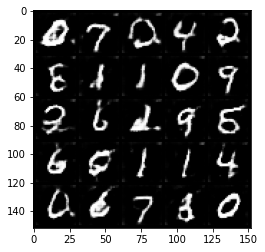

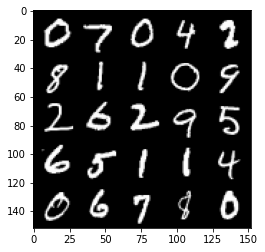

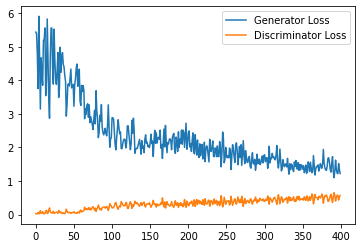

Step 8500: Generator loss: 1.308085902094841, discriminator loss: 0.5322543846964836


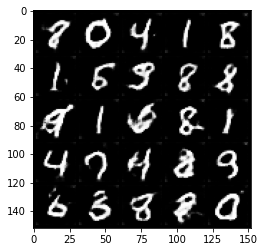

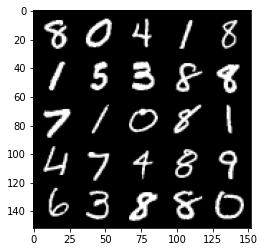

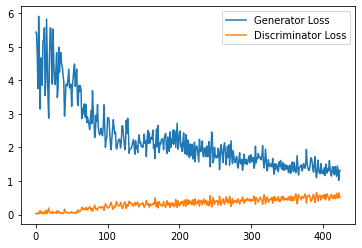

Step 9000: Generator loss: 1.2530051777362823, discriminator loss: 0.5345232667922973


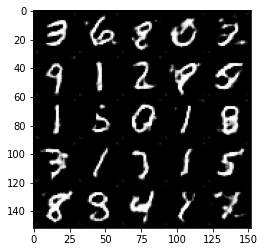

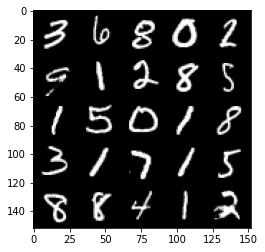

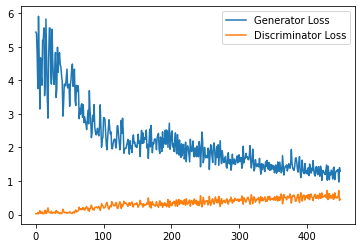

Step 9500: Generator loss: 1.2258053179979325, discriminator loss: 0.5450880912542343


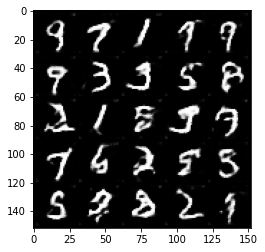

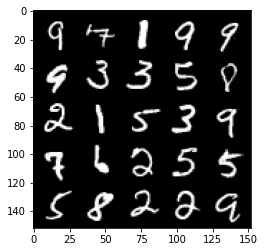

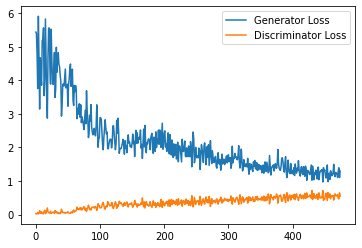

Step 10000: Generator loss: 1.2037558995485307, discriminator loss: 0.5329589596390725


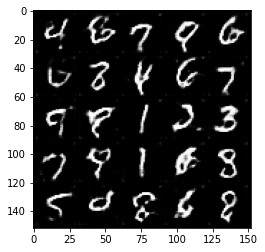

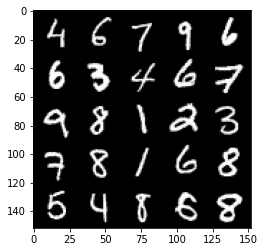

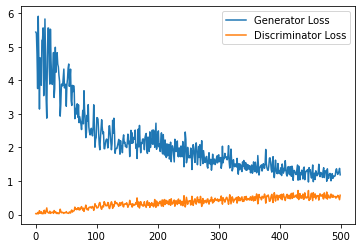

Step 10500: Generator loss: 1.257560557961464, discriminator loss: 0.5348581421375275


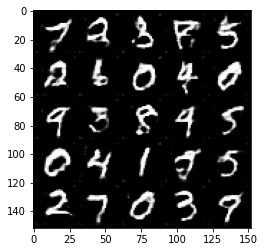

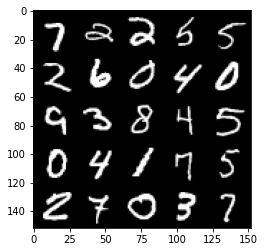

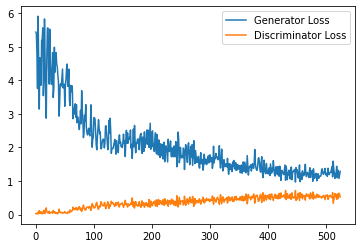

Step 11000: Generator loss: 1.1889215997457505, discriminator loss: 0.5517674816250802


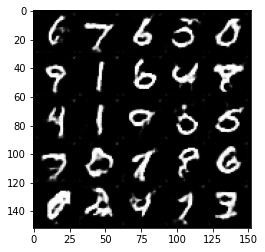

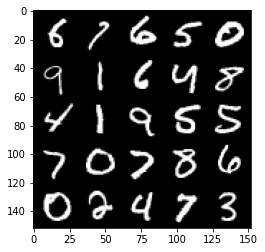

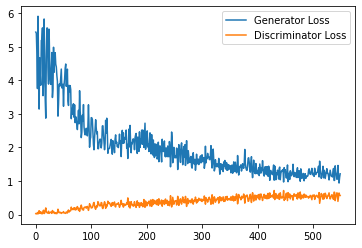

Step 11500: Generator loss: 1.2095257613658905, discriminator loss: 0.5430037851929664


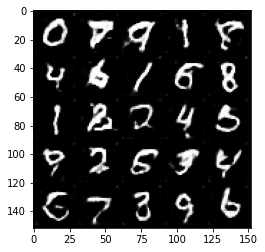

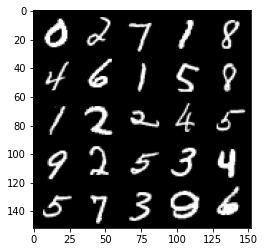

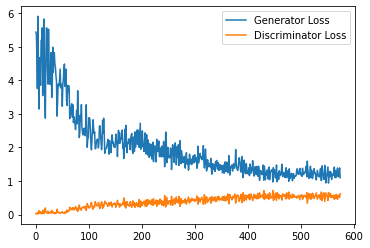

Step 12000: Generator loss: 1.1982609728574753, discriminator loss: 0.5557910482883454


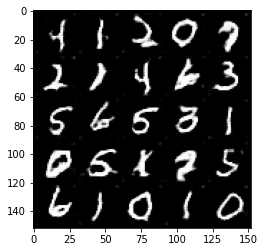

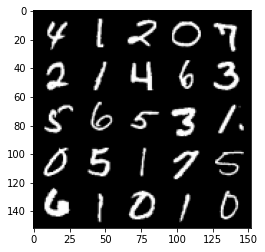

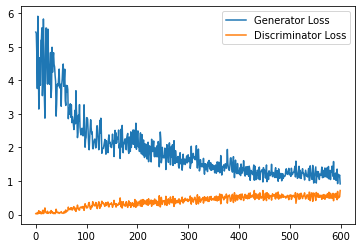

Step 12500: Generator loss: 1.1458589231967926, discriminator loss: 0.5487400872111321


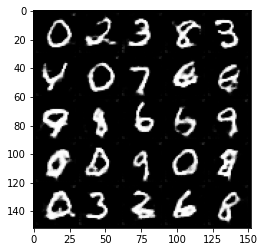

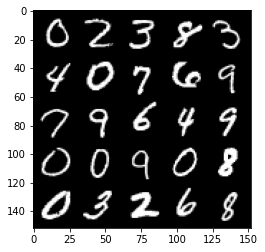

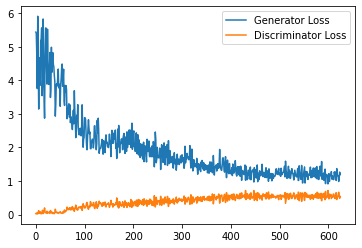

Step 13000: Generator loss: 1.1095440729856492, discriminator loss: 0.5569180079102516


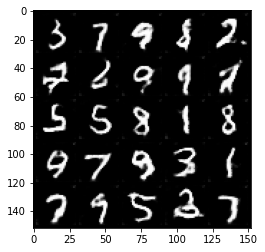

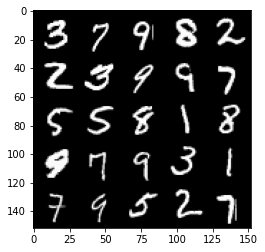

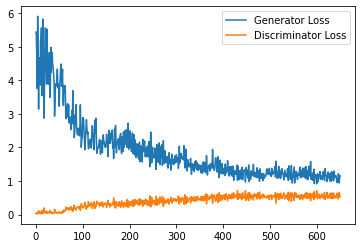

Step 13500: Generator loss: 1.1869770363569259, discriminator loss: 0.5620459467768669


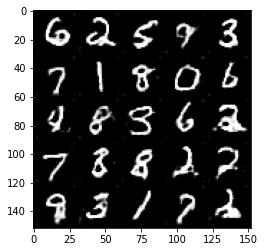

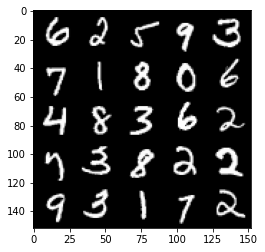

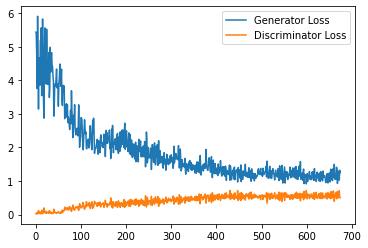

Step 14000: Generator loss: 1.0953195663690567, discriminator loss: 0.5634413781166077


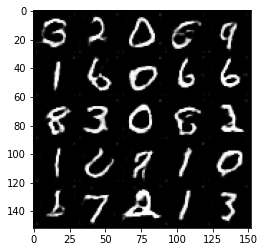

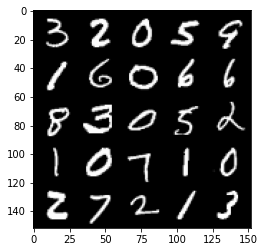

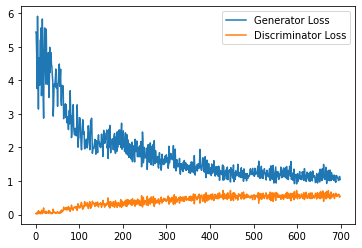

Step 14500: Generator loss: 1.1232268443107605, discriminator loss: 0.5564058822393417


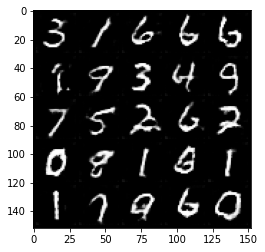

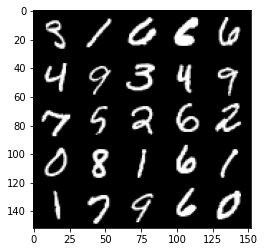

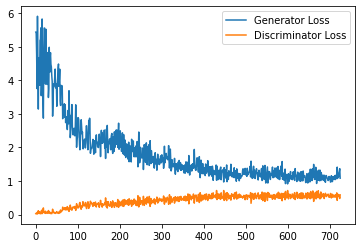

Step 15000: Generator loss: 1.1500832966566086, discriminator loss: 0.565234912097454


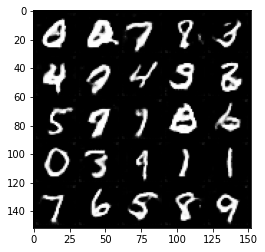

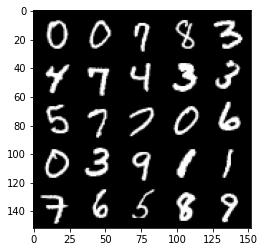

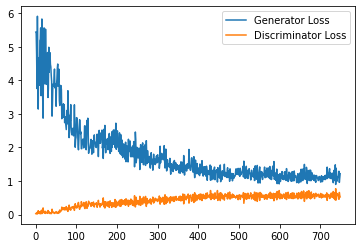

Step 15500: Generator loss: 1.1132148250341416, discriminator loss: 0.5639293785691262


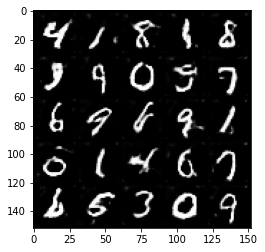

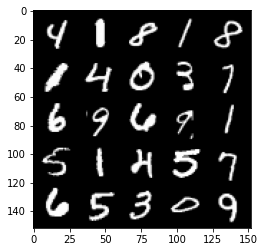

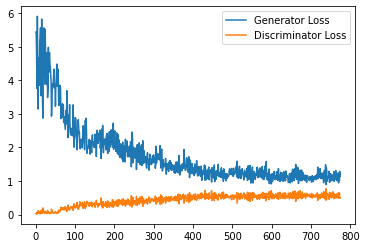

Step 16000: Generator loss: 1.1566829462051391, discriminator loss: 0.558913232088089


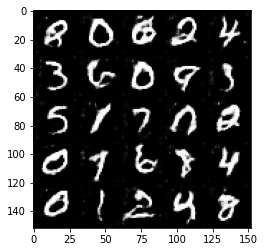

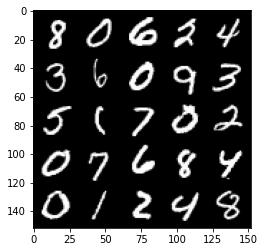

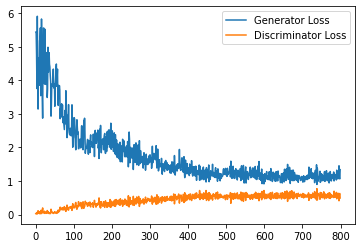

Step 16500: Generator loss: 1.1118928335905076, discriminator loss: 0.5678751787543297


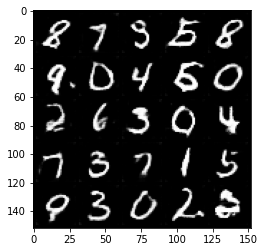

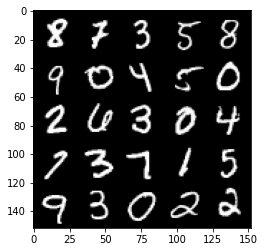

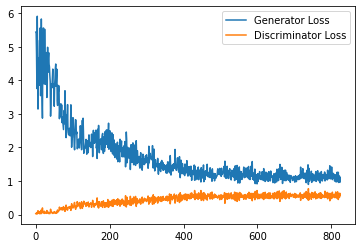

Step 17000: Generator loss: 1.104178411602974, discriminator loss: 0.560640533208847


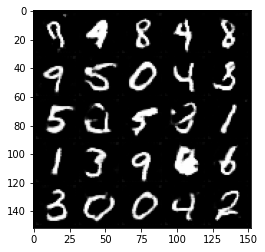

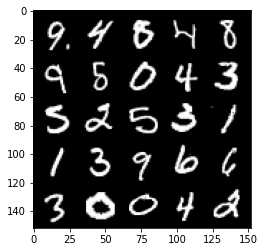

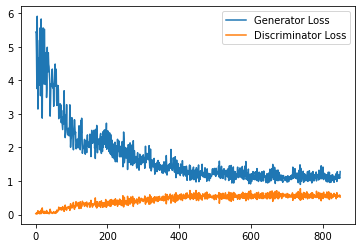

Step 17500: Generator loss: 1.1037900229692459, discriminator loss: 0.5710819877386093


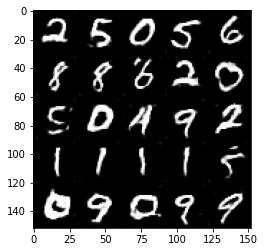

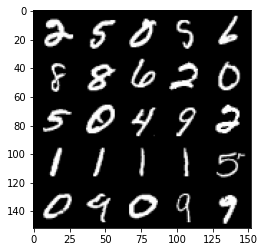

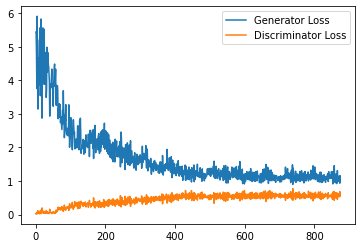

Step 18000: Generator loss: 1.0966638185977935, discriminator loss: 0.5682992861270905


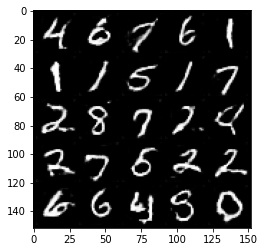

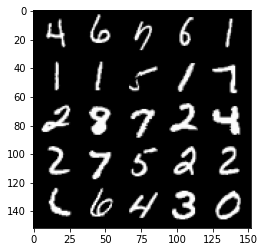

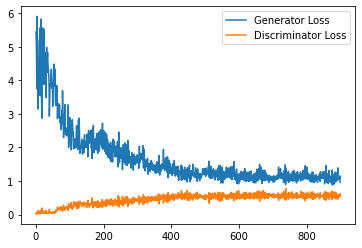

Step 18500: Generator loss: 1.0672162852287292, discriminator loss: 0.5774927240610123


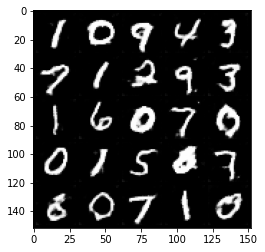

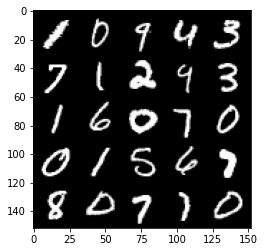

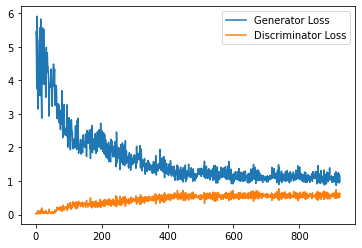

Step 19000: Generator loss: 1.0732761987447739, discriminator loss: 0.5747232477664947


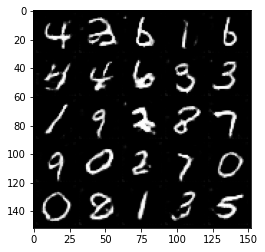

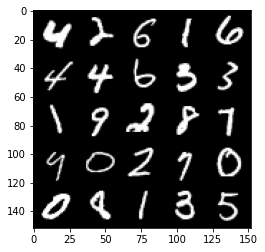

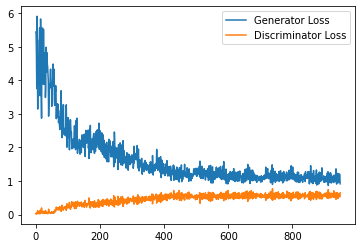

Step 19500: Generator loss: 1.0533531430959702, discriminator loss: 0.5790078203678131


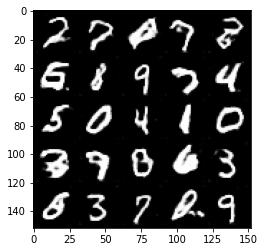

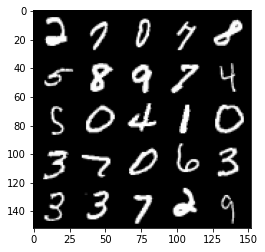

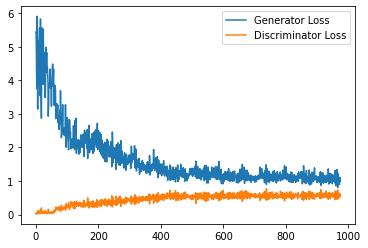

Step 20000: Generator loss: 1.0451543486118318, discriminator loss: 0.5775513969659806


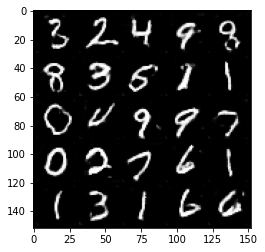

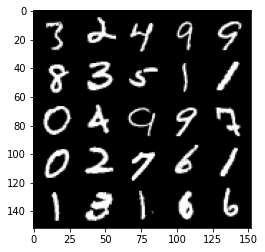

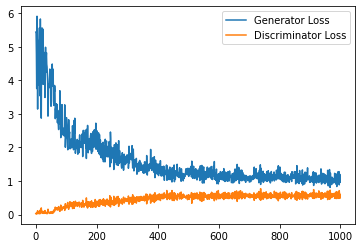

Step 20500: Generator loss: 1.0543555470705033, discriminator loss: 0.5810676943659783


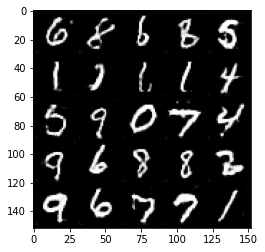

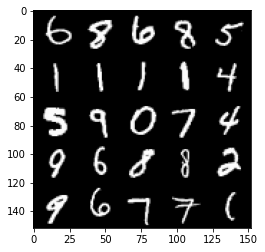

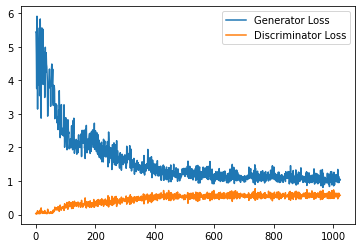

Step 21000: Generator loss: 1.0667995582818985, discriminator loss: 0.5801825395226479


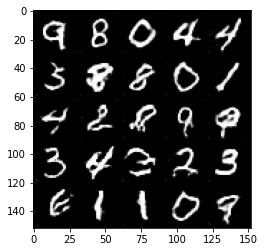

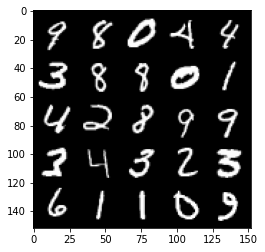

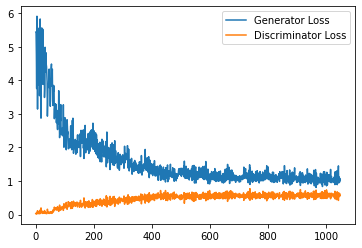

Step 21500: Generator loss: 1.0592140609025955, discriminator loss: 0.5852292600870133


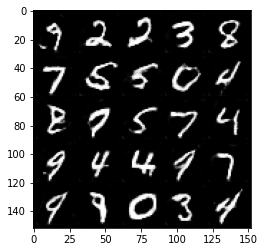

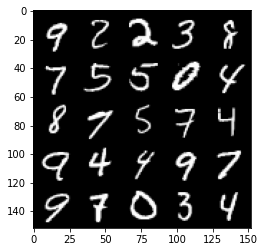

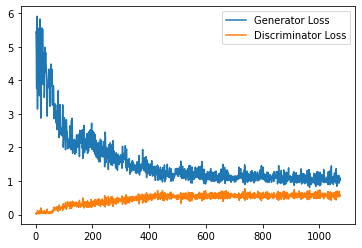

Step 22000: Generator loss: 1.0686460357904435, discriminator loss: 0.5865761697888374


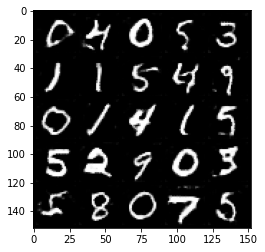

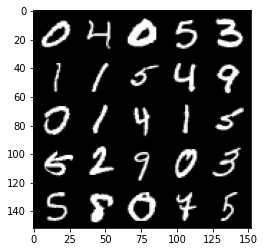

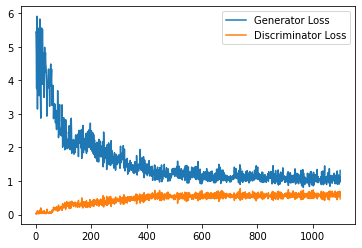

Step 22500: Generator loss: 1.0468744633197784, discriminator loss: 0.5924464790225029


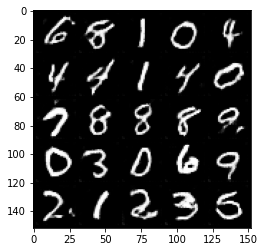

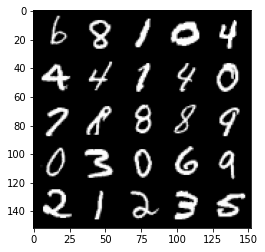

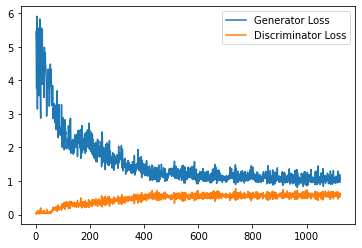

Step 23000: Generator loss: 1.0444166218042374, discriminator loss: 0.5973130081295968


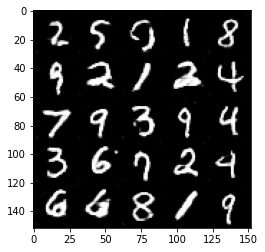

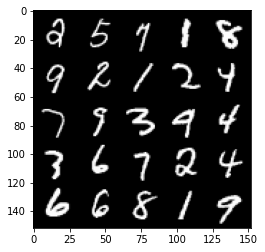

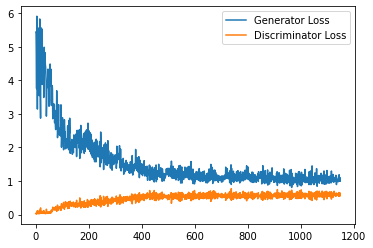

Step 23500: Generator loss: 1.0591956439018249, discriminator loss: 0.5936982883810997


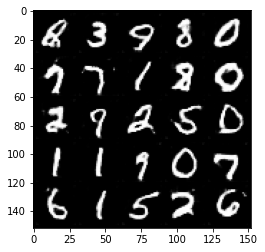

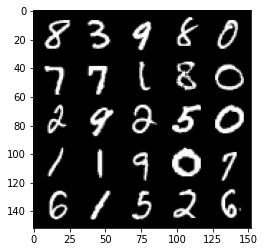

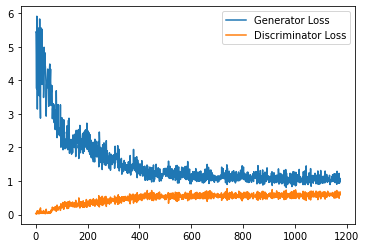

KeyboardInterrupt: ignored

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])
        #if epoch == 0:
          #print(image_one_hot_labels.shape)

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        #noise_dim, disc_dim = get_input_dimensions(z_dim, mnist_shape, n_classes)
        fake = gen(noise_and_labels)
        #### END CODE HERE ####
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        ###
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1



##Exploration
You can do a bit of exploration now!

In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

**Changing the Class Vector**

You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

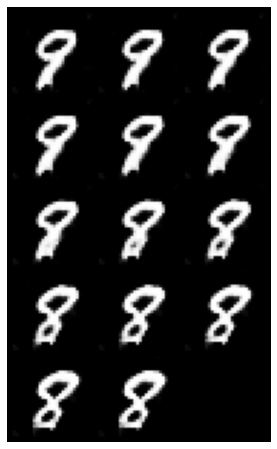

In [ ]:
import math

### Change me! ###
n_interpolation = 14 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 9 # Choose the start digit
### Change me! ###
end_plot_number = 8 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
# plot_numbers = [2, 3, 4, 5, 7]
# n_numbers = len(plot_numbers)
# plt.figure(figsize=(8, 8))
# for i, first_plot_number in enumerate(plot_numbers):
#     for j, second_plot_number in enumerate(plot_numbers):
#         plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
#         interpolate_class(first_plot_number, second_plot_number)
#         plt.axis('off')
# plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
# plt.show()
# plt.close()

**Changing the Noise Vector**

Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

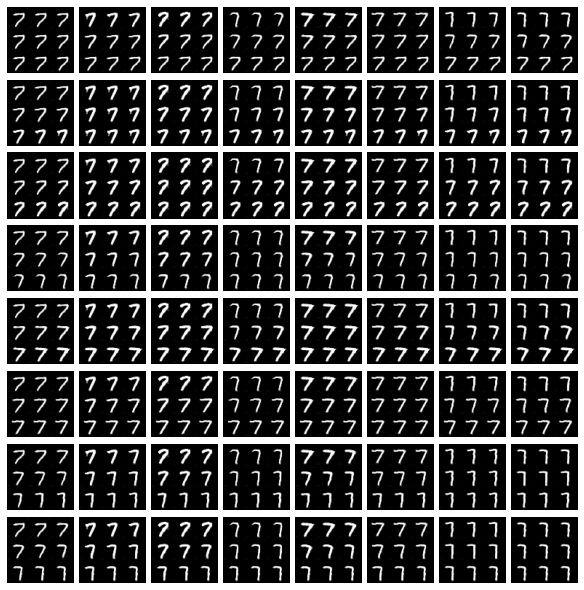

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([7]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 8 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()